In [76]:
import numpy as np
from utils import mnist_reader

import plotly.express as px
from gtda.plotting import plot_point_cloud

from gtda.images import (
    Binarizer, Inverter,
    HeightFiltration, RadialFiltration,
    DilationFiltration, ErosionFiltration,
    SignedDistanceFiltration
)

from gtda.homology import CubicalPersistence

from gtda.diagrams import (
    Scaler, Filtering,
    PersistenceLandscape, BettiCurve, HeatKernel,
    PersistenceImage, Silhouette,
    Amplitude, PersistenceEntropy
)

from gtda.pipeline import Pipeline

from gtda.plotting import (
    plot_heatmap, plot_diagram, plot_betti_curves
)

# ML tools
from sklearn.cluster import DBSCAN # cluster algo
from sklearn.decomposition import PCA 

In [77]:
x_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
x_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [78]:
x_train = x_train.reshape((-1,28,28))
x_test = x_test.reshape((-1,28,28))

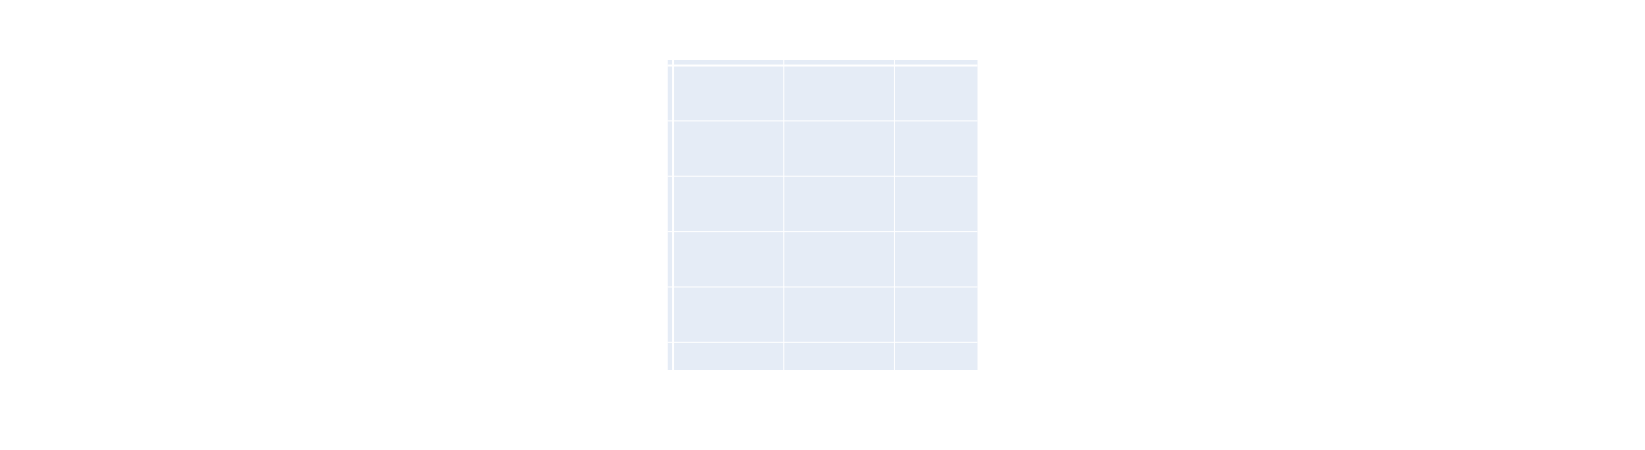

In [80]:
img = x_train[45]
fig = px.imshow(img, color_continuous_scale='gray')
fig.update_layout(coloraxis_showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

In [113]:
import itertools

# Pipeline parameters
bin_thresholds = [0.25, 0.5, 0.75]
directions = [np.array([np.cos(t), np.sin(t)]) for t in np.linspace(0, 2 * np.pi, 7)[:-1]]
centers = [np.array(p) for p in itertools.product((7,14,21),(7,14,21))]

In [114]:
p = make_pipeline(Binarizer(threshold=0.25), CubicalPersistence(),  Amplitude(metric='betti'))

In [115]:
betti = p.fit_transform(x_train[34:35,:])
betti

array([[8.24621125]])

In [116]:
# Vectorizations, we use L^2 for kernels by default and default n_bins
# Note, we are not acutally using kernel vectors, just their amplitudes for now
features = [('bottleneck', Amplitude(metric='bottleneck')), 
            ('wasserstein', Amplitude(metric='wasserstein')),
            ('landscape', Amplitude(metric='landscape')),
            ('betti', Amplitude(metric='betti')),
            ('silhouette', Amplitude(metric='silhouette')),
            ('heat_10', Amplitude(metric='heat', metric_params={'sigma': 10})),
            ('heat_15', Amplitude(metric='heat', metric_params={'sigma': 15})),
            #('PI_10', Amplitude(metric='persistence_image', metric_params={'sigma': 10})),
            #('PI_15', Amplitude(metric='persistence_image', metric_params={'sigma': 15})),
            ('PE', PersistenceEntropy())]

# Make filtrations
binned_steps = [('binarizer_{}'.format(t), Binarizer(threshold=t)) for t in bin_thresholds]

filtrations = [('height_{}'.format(d), HeightFiltration(direction=d)) for d in directions]
filtrations.extend([('radial_{}'.format(c), RadialFiltration(center=c)) for c in centers])
filtrations.append(('dilation', DilationFiltration()))
filtrations.append(('erosion', ErosionFiltration()))
filtrations.append(('signed', SignedDistanceFiltration()))

# Make pipelines
cubical_lower = [('cubical', CubicalPersistence())]
cubical_upper = [('inverter', Inverter()), ('cubical', CubicalPersistence())]

partial_pipeline_steps = [cubical_lower, cubical_upper]

for b, f in itertools.product(binned_steps, filtrations):
    partial_pipeline_steps.append([b,f, ('cubical', CubicalPersistence())])
    

feature_pipelines = []
for s, f in itertools.product(partial_pipeline_steps, features):
    feature_pipelines.append(Pipeline(s + [f]))
    
len(feature_pipelines)

448

In [117]:
# get small slice of data to play with
fashion_data = np.array(x_train)
idx = np.random.randint(60000, size=10)
sandbox_data = fashion_data[idx,:]

In [119]:
results = np.zeros((len(sandbox_data),len(feature_pipelines)))
for i, p in enumerate(feature_pipelines[:5]):
    results[:,i] = p.fit_transform(sandbox_data)[:,0]

In [120]:
results[:,:5]

array([[ 146.67140144,  178.34026466, 1278.96470512,   96.22810652,
        1064.98386534],
       [ 180.3122292 ,  207.39877049, 1662.31180366,   76.24621203,
        1383.63296192],
       [ 165.80787074,  223.20338259, 1475.15587185,  140.47376548,
        1006.94339458],
       [ 157.51984002,  198.03030071, 1422.64367231,   89.18486079,
        1062.51947134],
       [ 136.7717076 ,  248.914644  , 1240.73738922,  164.02374181,
         682.19655859],
       [ 134.08392894,  163.48012112, 1201.13394391,   94.308488  ,
        1062.33348084],
       [ 142.88631845,  195.94578332, 1266.60018867,  140.23519206,
         916.47172581],
       [ 148.17725871,  197.03806739, 1291.7588741 ,  135.76494839,
         849.57591687],
       [ 158.70255196,  253.00197628, 1451.68559486,  162.0171147 ,
        1032.07450427],
       [ 132.21667822,  170.29092753, 1187.5169456 ,  126.279512  ,
         887.93298797]])